In [3]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 300}
%matplotlib inline

In [4]:
%aimport dlqmc.NN, dlqmc.Sampler, dlqmc.Examples
%aimport dlqmc.utils, dlqmc.sampling, dlqmc.analysis, dlqmc.gto, dlqmc.physics, dlqmc.nn, dlqmc.fit

In [79]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pyscf
from pyscf import gto, scf
from pyscf.data.nist import BOHR
from tqdm.auto import tqdm, trange
from tensorboardX import SummaryWriter

from dlqmc.nn import WFNet, DistanceBasis
from dlqmc.fit import fit_wfnet, loss_local_energy, wfnet_fit_driver
from dlqmc.sampling import samples_from, langevin_monte_carlo
from dlqmc.physics import local_energy
from dlqmc.gto import GTOWF
from dlqmc.analysis import autocorr_coeff, blocking
from dlqmc.utils import (
    plot_func, plot_func_xy, plot_func_x, integrate_on_mesh, form_geom, as_pyscf_atom
)

In [14]:
h_atom = form_geom([[1, 0, 0]], [1])
h2_plus = form_geom([[-1, 0, 0], [1, 0, 0]], [1, 1])
h2_mol = form_geom([[0, 0, 0], [0.742/BOHR, 0, 0]], [1, 1])

## GTO WF

In [73]:
mol = gto.M(
    atom=as_pyscf_atom(h2_plus),
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
scf_energy_big = mf.kernel()
gtowf_big = GTOWF(mf, 0)

converged SCF energy = -0.602622271479772


In [74]:
mol = gto.M(
    atom=as_pyscf_atom(h2_plus),
    unit='bohr',
    basis='6-311g',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
scf_energy = mf.kernel()
gtowf = GTOWF(mf, 0, use_pyscf=False)

converged SCF energy = -0.590478992645743


(-1, 1)

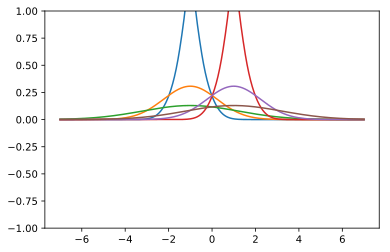

In [8]:
plot_func_x(lambda x: pyscf.dft.numint.eval_ao(mol, x), [-7, 7], is_torch=False);
plt.ylim(-1, 1)

(-1, 1)

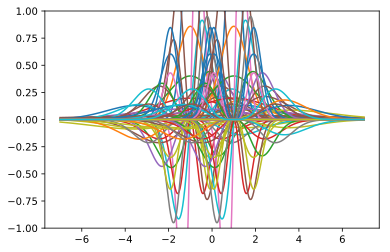

In [9]:
plot_func_x(lambda x: pyscf.dft.numint.eval_ao(gtowf_big._mol, x), [-7, 7], is_torch=False);
plt.ylim(-1, 1)

In [218]:
integrate_on_mesh(lambda x: gtowf(x.cuda())**2, [(-6, 6), (-4, 4), (-4, 4)])

tensor(0.9931, device='cuda:0')

In [222]:
torch.randn(100, 2, 3).squeeze(dim=1).shape

torch.Size([100, 2, 3])

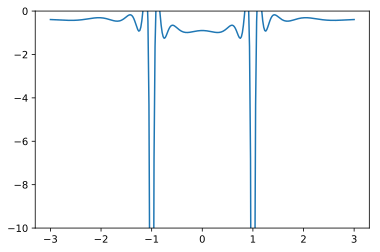

In [226]:
plot_func_x(lambda x: local_energy(x[:, None], gtowf, h2_plus)[0], [-3, 3])
plt.ylim((-10, 0));

In [228]:
n_walker = 1_000
sampler = langevin_monte_carlo(
    gtowf,
    torch.randn(n_walker, 1, 3),
    tau=0.1,
)
samples, info = samples_from(sampler, trange(500))
E_loc = local_energy(samples.flatten(end_dim=1), gtowf, h2_plus)[0].view(n_walker, -1)
info.acceptance.mean()

0.9786199999999999

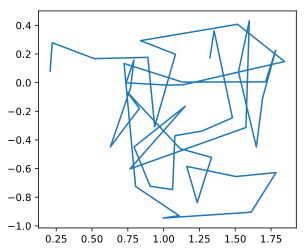

In [231]:
plt.plot(*samples[0][:50, 0, :2].numpy().T)
plt.gca().set_aspect(1)

(-0.7, -0.5)

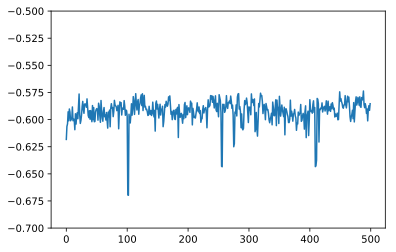

In [232]:
plt.plot(E_loc.mean(dim=0).numpy())
plt.ylim(-0.7, -0.5)

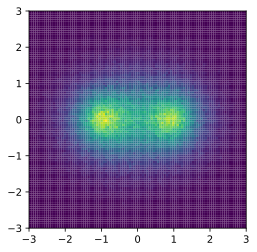

In [239]:
plt.hist2d(
    *samples[:, 50:].flatten(end_dim=1)[:, 0, :2].numpy().T,
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

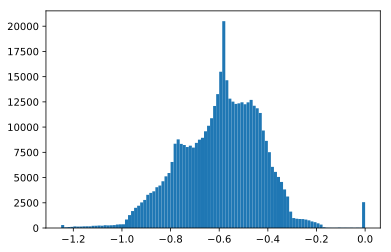

In [240]:
plt.hist(E_loc[:, 50:].flatten().clamp(-1.25, 0).numpy(), bins=100);

In [241]:
E_loc[:, 50:].std()

tensor(0.3521)

In [242]:
scf_energy, E_loc[:, 50:].mean().item(), (E_loc[:, 50:].mean(dim=1).std()/np.sqrt(E_loc.shape[0])).item()

(-0.5904789926457441, -0.5920525193214417, 0.0009967447258532047)

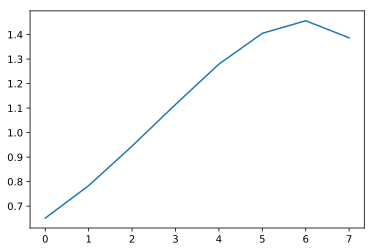

In [243]:
plt.plot(blocking(E_loc[:, 50:]).numpy())

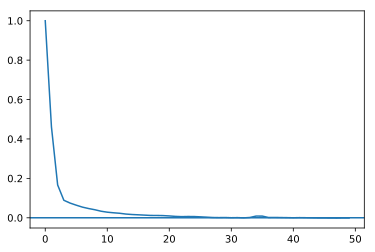

In [244]:
plt.plot(autocorr_coeff(range(50), E_loc[:, 50:]).numpy())
plt.axhline()

## Net WF

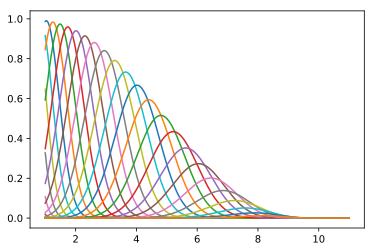

In [55]:
plot_func(DistanceBasis(32), [1, 11]);

In [64]:
wfnet = WFNet(h2_plus, 1, ion_pot=0.7).cuda()
sampler = langevin_monte_carlo(
    wfnet,
    torch.randn(1_000, 1, 3, device='cuda'),
    tau=0.1,
)

In [65]:
exp_label = 'exp28'
with SummaryWriter(f'runs/{exp_label}/pretrain') as writer:
    fit_wfnet(
        wfnet,
        partial(loss_local_energy, E_ref=-0.5),
        torch.optim.Adam(wfnet.parameters(), lr=0.005),
        wfnet_fit_driver(
            sampler,
            samplings=range(1),
            n_epochs=5,
            n_sampling_steps=550,
            batch_size=10_000,
            n_discard=50,
            range_sampling=partial(trange, desc='sampling steps', leave=False),
            range_training=partial(trange, desc='training steps', leave=False),
        ),
        writer=writer,
    )
with SummaryWriter(f'runs/{exp_label}/variance') as writer:
    fit_wfnet(
        wfnet,
        loss_local_energy,
        torch.optim.Adam(wfnet.parameters(), lr=0.005),
        wfnet_fit_driver(
            sampler,
            samplings=trange(10, desc='samplings'),
            n_epochs=5,
            n_sampling_steps=550,
            batch_size=10_000,
            n_discard=50,
            range_sampling=partial(trange, desc='sampling steps', leave=False),
            range_training=partial(trange, desc='training steps', leave=False),
        ),
        writer=writer,
    )
wfnet.cpu()

WFNet(
  (dist_basis): DistanceBasis()
  (nuc_asymp): NuclearAsymptotic()
  (geom): ParameterDict(
      (charges): Parameter containing: [torch.FloatTensor of size 2]
      (coords): Parameter containing: [torch.FloatTensor of size 2x3]
  )
  (deep_lin): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): SSP(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SSP(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (_pdist): PairwiseDistance3D()
  (_psdist): PairwiseSelfDistance3D()
)

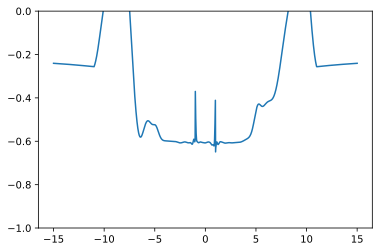

In [66]:
plot_func_x(
    lambda x: local_energy(x[:, None], wfnet, wfnet.geom)[0],
    [-15, 15],
)
plt.ylim((-1, 0));

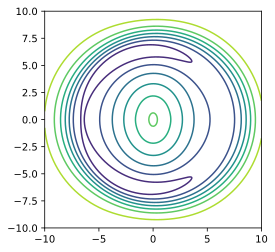

In [67]:
plot_func_xy(
    lambda x: wfnet.deep_lin(wfnet._featurize(x[:, None])[0]).squeeze(),
    [[-10, 10], [-10, 10]]
);

In [68]:
n_walker = 1_000
sampler = langevin_monte_carlo(
    wfnet.cuda(),
    torch.randn(n_walker, 1, 3, device='cuda'),
    tau=0.1,
)
samples, info = samples_from(sampler, trange(500))
E_loc = local_energy(samples.flatten(end_dim=1), wfnet, wfnet.geom)[0].view(n_walker, -1)
samples = samples.cpu()
E_loc = E_loc.cpu()
wfnet.cpu()
info.acceptance.mean()

0.97836

(-0.7, -0.5)

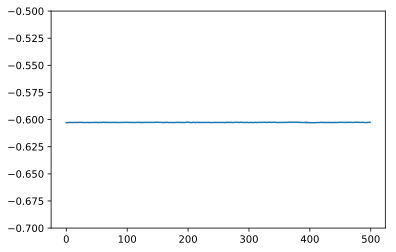

In [69]:
plt.plot(E_loc.mean(dim=0).numpy())
plt.ylim(-0.7, -0.5)

(-1.25, 0)

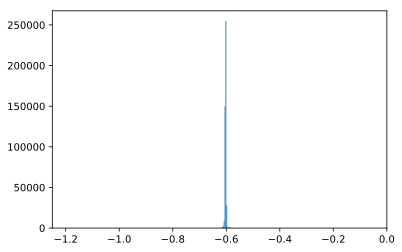

In [70]:
plt.hist(E_loc[:, 50:].flatten().clamp(-1.25, 0).numpy(), bins=100);
plt.xlim(-1.25, 0)

In [71]:
E_loc[:, 50:].std()

tensor(0.0031)

In [75]:
scf_energy_big, E_loc[:, 50:].mean().item(), (E_loc[:, 50:].mean(dim=1).std()/np.sqrt(E_loc.shape[0])).item()

(-0.602622271479772, -0.6026187539100647, 1.1713910680555273e-05)

(-1.5, -0.5970840960741043)

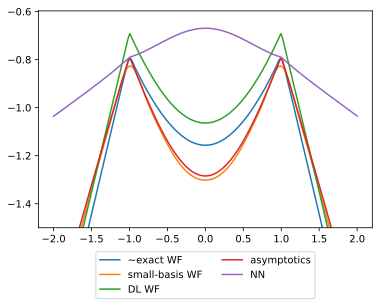

In [87]:
bounds = [-2, 2]
plot_func_x(lambda x: torch.log(gtowf_big(x[:, None])), bounds, label='~exact WF');
plot_func_x(lambda x: torch.log(gtowf(x[:, None])), bounds, label='small-basis WF');
plot_func_x(lambda x: torch.log(wfnet(x[:, None]))-0.2, bounds, label='DL WF');
plot_func_x(lambda x: torch.log(wfnet.nuc_asymp(wfnet._featurize(x[:, None])[1][0]))-0.89, bounds, label='asymptotics');
plot_func_x(lambda x: wfnet.deep_lin(wfnet._featurize(x[:, None])[0]).squeeze()-0.2, bounds, label='NN');
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)
plt.ylim(-1.5, None)

## H2

In [15]:
wfnet = WFNet(h2_mol, 2, ion_pot=0.7).cuda()

In [16]:
n_walker = 1_000
sampler = langevin_monte_carlo(
    wfnet.cuda(),
    torch.randn(n_walker, 2, 3, device='cuda'),
    tau=0.1,
)
samples, info = samples_from(sampler, trange(500))
E_loc = local_energy(samples.flatten(end_dim=1), wfnet, wfnet.geom)[0].view(n_walker, -1)
samples = samples.cpu()
E_loc = E_loc.cpu()
wfnet.cpu()
info.acceptance.mean()

0.969716

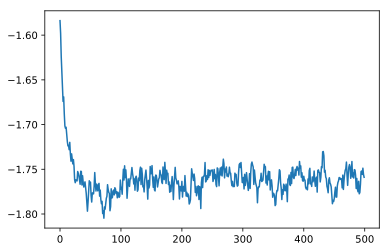

In [17]:
plt.plot(E_loc.mean(dim=0).numpy())